# Set up the environment
The software we will use includes:
- Gmsh -- https://gmsh.info: for defining our detector geometry and creating a finite element mesh
- Elmer -- http://www.elmerfem.org: for solving for the electrostatic fields
- ROOT -- https://root.cern.ch: a prerequisite for Garfield++ (with Python enabled). Note that for this example a version of ROOT has been compiled with Python 3.
- Garfield++ -- https://garfieldpp.web.cern.ch/garfieldpp: for detector simulation

The entire development environment has already been prepared to run the code in this notebook on Google Colab and will be downloaded directly below. This setup is documented in another notebook:

https://colab.research.google.com/github/jerenner/garfieldfem/blob/master/garfield_FEM_install.ipynb

It can be followed to perform a similar installation on a local machine.

**Get the pre-compiled binaries**

In [3]:
!wget https://www.dropbox.com/s/ron3hjegmwu7ram/environ.tar.gz
!tar -xvf environ.tar.gz
!apt-get install libgsl-dev

Streaming output truncated to the last 5000 lines.
root/install/etc/cling/lib/clang/5.0.0/include/avx512vpopcntdqintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/htmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/bmi2intrin.h
root/install/etc/cling/lib/clang/5.0.0/include/avx512fintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/xsaveoptintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/xsaveintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/stdatomic.h
root/install/etc/cling/lib/clang/5.0.0/include/rtmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/immintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/armintr.h
root/install/etc/cling/lib/clang/5.0.0/include/mmintrin.h
root/install/etc/cling/lib/clang/5.0.0/include/stdnoreturn.h
root/install/etc/cling/lib/clang/5.0.0/include/avx2intrin.h
root/install/etc/cling/lib/clang/5.0.0/include/module.modulemap
root/install/etc/cling/lib/clang/5.0.0/include/arm_acle.h
root/install/etc/cling/lib/clang/5.0

**Set environment variables and load the necessary libraries**

In [4]:
import numpy as np

# Set the environment variables.
import os
os.environ["GARFIELD_HOME"] = "/content/garfield/garfieldpp"
os.environ["ROOTSYS"] = "/content/root/install"
os.environ["PATH"] += ":/content/elmer/install/bin"

# Load the ROOT and Garfield libraries.
import sys
sys.path.append("/content/root/install/lib")

import ctypes
ctypes.cdll.LoadLibrary('/content/root/install/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libtbb.so.2')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGeom.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libXMLIO.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGdml.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/root/install/lib/libcppyy_backend3_7.so')

import ROOT
ROOT.gSystem.Load("/content/garfield/install/lib/libGarfield.so")
%jsroot off

import gmsh

# Change the working directory.
working_dir = "/content/examples"
if(not os.path.isdir(working_dir)):
  os.mkdir(working_dir)
os.chdir(working_dir)

Welcome to JupyROOT 6.22/02


In [9]:
# Set up the gas medium.
gas = ROOT.Garfield.MediumMagboltz()
gas.SetTemperature(293.15)
gas.SetPressure(760.)
gas.SetComposition("ar", 90., "co2", 10.)
gas.EnableDrift()

MediumMagboltz::SetComposition:
    Ar/CO2 (90/10)


In [12]:
#Electric field [kV / cm].
field = 20. 
#Gas gap [cm]
gap = 0.1

#Make a drift volume.
box = ROOT.Garfield.SolidBox(0, 0, gap, 2, 2, gap)
geo = ROOT.Garfield.GeometrySimple()
geo.AddSolid(box, gas)

#Make a component with constant drift field.
cmp = ROOT.Garfield.ComponentConstant()
cmp.SetGeometry(geo)
cmp.SetElectricField(0, 0, field * 1.e3);

#Make a sensor.
sensor = ROOT.Garfield.Sensor()
sensor.AddComponent(cmp)

In [13]:
nBins = 50
hElectrons = ROOT.TH1I("hElectrons", "Number of electrons", nBins, -0.5, nBins - 0.5);

#Microscopic tracking.
aval = ROOT.Garfield.AvalancheMicroscopic()
aval.SetSensor(sensor)

ne = ctypes.c_int()
ni = ctypes.c_int()

nEvents = 50;
for j in range (0,nEvents):
  if (j % 10 == 0):
    print(j,"/",nEvents, end="\n")
  #Initial electron energy [eV].
  e0 = 1.;
  aval.AvalancheElectron(0, 0, gap, 0, e0, 0, 0, 0);
  aval.GetAvalancheSize(ne, ni);
  gain = ne.value
  print(gain)
  hElectrons.Fill(gain)

0 / 50
649
499
637
2702
670
1513
1569
1336
357
699
10 / 50
3139
771
85
0
183
172
1029
2467
1133
1331
20 / 50
0
1282
1057
1222
0
947
29
455
443
748
30 / 50
0
750
1353
253
2150
233
828
1048
389
1349
40 / 50
335
928
202
2064
1761
1701
63
0
1073
1839
Sensor::SetArea:
    -2 < x [cm] < 2
    -2 < y [cm] < 2
    0 < z [cm] < 0.2


Warning in <TROOT::Append>: Replacing existing TH1: hElectrons (Potential memory leak).


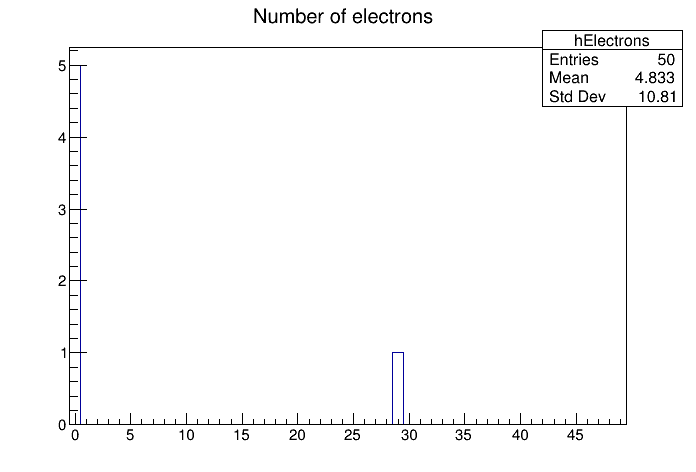

In [14]:
c = ROOT.TCanvas()
hElectrons.Draw("h")
c.Draw()